# Proyek Klasifikasi Gambar: Indonesian Rupiah Currency
- **Nama:** Dinda Alicya Ruiz
- **Email:** alicyaruiz1902@gmail.com
- **ID Dicoding:** dlicyaa
- **Student ID:** MS004D5X0492 (CodingCamp Powered by DBS Foundation)

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install tensorflow

In [36]:
from google.colab import drive
import os
import shutil
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import random
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.models import Sequential
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

### Data Loading

In [3]:
# Mount Google Drive
drive.mount('/content/drive')

data_rupiah = '/content/drive/MyDrive/Colab Notebooks/klasifikasi_gambar/rupiah'
base_dir = '/content/drive/My Drive/Colab Notebooks/klasifikasi_gambar/split_dir'

Mounted at /content/drive


In [4]:
# menghitung jumlah gambar pada dataset

total_images = 0
number_label = {}
for folder in os.listdir(data_rupiah):
    folder_path = os.path.join(data_rupiah, folder)
    if os.path.isdir(folder_path):
        jumlah_gambar = len(os.listdir(folder_path))
        number_label[folder] = jumlah_gambar
        total_images += jumlah_gambar
        print(f"Jumlah gambar {folder}: {jumlah_gambar}")
print(f"\nTotal semua gambar pada dataset: {total_images}")

Jumlah gambar 100000: 344
Jumlah gambar 5000: 345
Jumlah gambar 2000: 344
Jumlah gambar 20000: 344
Jumlah gambar 1000: 334
Jumlah gambar 10000: 344
Jumlah gambar 50000: 354

Total semua gambar pada dataset: 2409


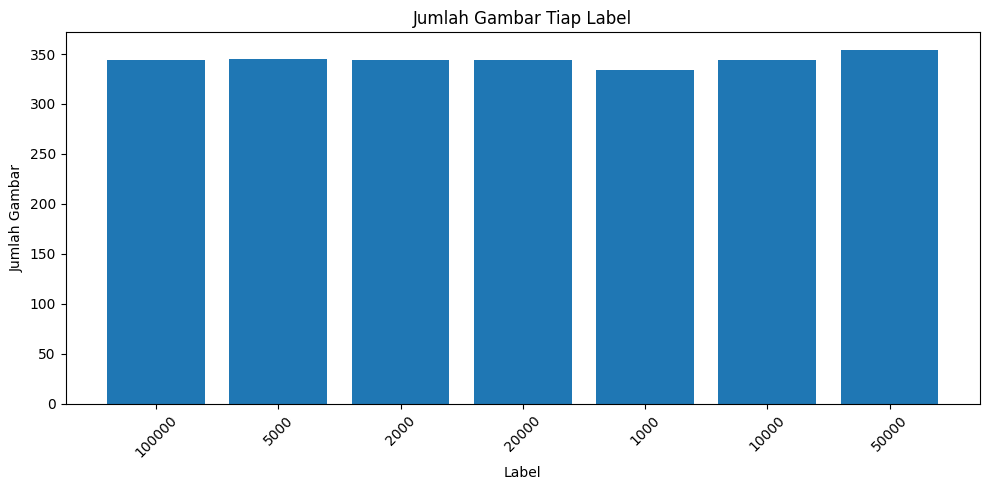

In [5]:
# distribusi jumlah gambar pada setiap kelas
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.bar(number_label.keys(), number_label.values())
plt.title("Jumlah Gambar Tiap Label")
plt.xlabel('Label')
plt.ylabel('Jumlah Gambar')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

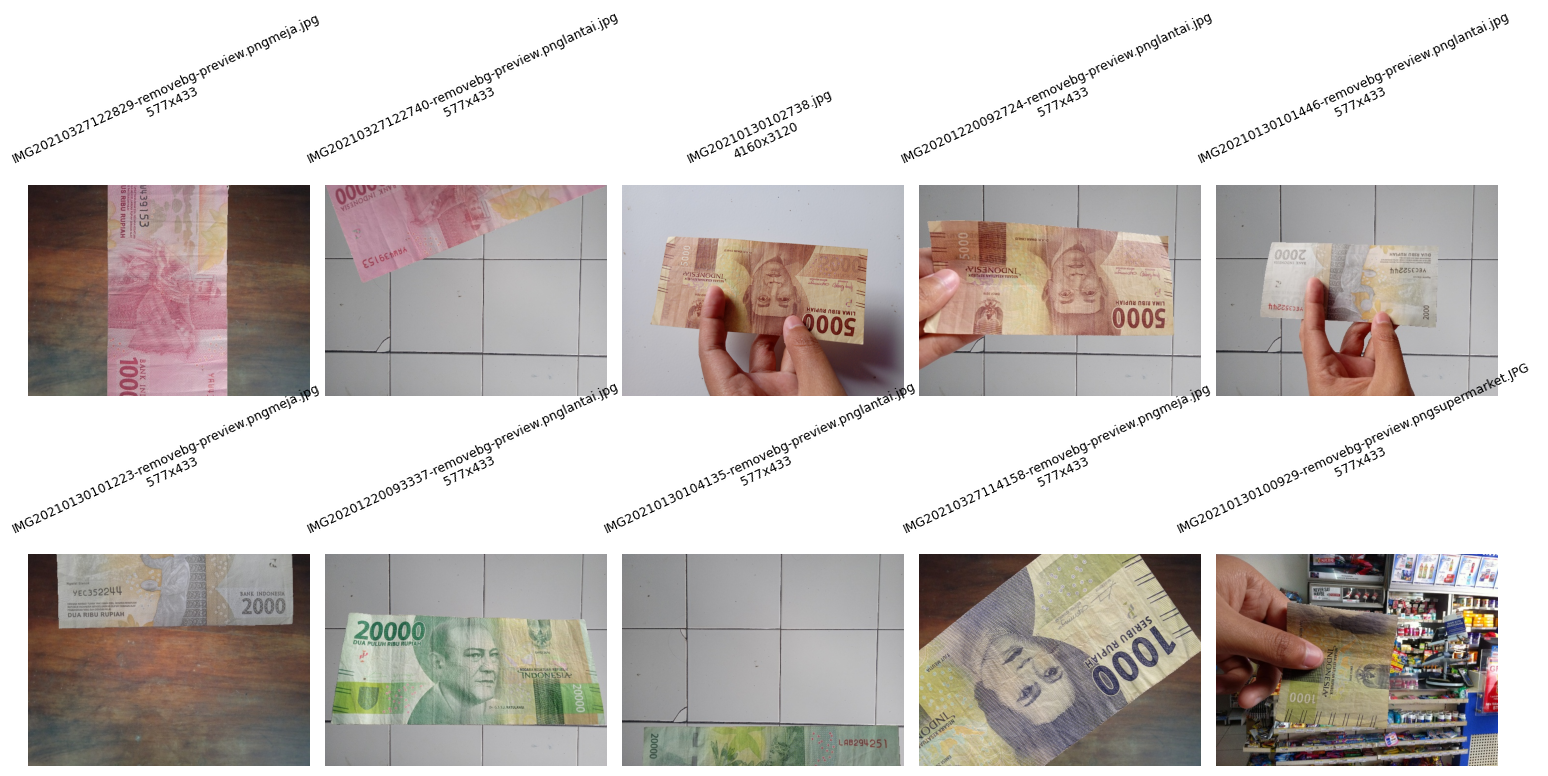

In [42]:

sample_paths = []
for class_name in os.listdir(data_rupiah):
    class_path = os.path.join(data_rupiah, class_name)
    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        sample_images = random.sample(images, min(2, len(images)))  # ambil max 2 gambar per kelas
        for img_name in sample_images:
            sample_paths.append(os.path.join(class_path, img_name))

# tampilkan sample gambar dan resolusi aslinya
plt.figure(figsize=(15, 8))
for i, img_path in enumerate(sample_paths[:10]):  # batasi 10 gambar agar tidak kepanjangan
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, c = img.shape

    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(f"{os.path.basename(img_path)}\n{w}x{h}", rotation=25, fontsize=9)
    plt.axis('off')
plt.tight_layout()
plt.show()


### Data Preprocessing

#### Split Dataset

In [6]:
#split dataset menjadi 3 bagian (train, validation, dan test)

for split in ['train', 'val', 'test']:
    for class_name in os.listdir(data_rupiah):
        split_dir = os.path.join(base_dir, split, class_name) # split dataset disimpan ke directory base_dir
        os.makedirs(split_dir, exist_ok=True)

In [7]:
# mulai splitting data

for class_name in os.listdir(data_rupiah):
    class_dir = os.path.join(data_rupiah, class_name)
    images = os.listdir(class_dir)

    train_files, temp_files = train_test_split(images, test_size=0.3, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

    for file_list, split in zip([train_files, val_files, test_files], ['train', 'val', 'test']):
        for filename in file_list:
            src = os.path.join(class_dir, filename)
            dst = os.path.join(base_dir, split, class_name, filename)
            shutil.copy2(src, dst)

In [8]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

dengan ini dataset sudah di split dengan bagian training data 70%, testing data 15% dan validation data 15%.

splitting data berada pada directory "split_dir"

### Rescale dan DataLoading

In [9]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1681 images belonging to 7 classes.
Found 363 images belonging to 7 classes.
Found 365 images belonging to 7 classes.


In [11]:
class_names = list(train_generator.class_indices.keys())
print(class_names)


['1000', '10000', '100000', '2000', '20000', '5000', '50000']


## Modelling

In [12]:
# membangun model sequential

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(train_generator.num_classes, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,863 (42.61 MB)

 Trainable params: 11,169,863 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
#menambahkan optimizer
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
# menambahkan fitur callback (training berhenti ketika sudah mencapai 95%)
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.95 and logs.get('val_accuracy')>0.95):
      print("akurasi model sudah mencapai 95%")
      self.model.stop_training = True

callbacks = myCallback()

In [16]:
num_epochs = 50
history = model.fit(
      train_generator,
      epochs=num_epochs,
      validation_data=val_generator,
      validation_steps=5,
      verbose=2,
      callbacks=[callbacks])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
53/53 - 247s - 5s/step - accuracy: 0.1457 - loss: 2.0091 - val_accuracy: 0.1813 - val_loss: 1.8557
Epoch 2/50
53/53 - 263s - 5s/step - accuracy: 0.2903 - loss: 1.6828 - val_accuracy: 0.3125 - val_loss: 1.5569
Epoch 3/50
53/53 - 254s - 5s/step - accuracy: 0.4509 - loss: 1.3464 - val_accuracy: 0.5875 - val_loss: 1.1573
Epoch 4/50
53/53 - 263s - 5s/step - accuracy: 0.6056 - loss: 1.0416 - val_accuracy: 0.6938 - val_loss: 0.8952
Epoch 5/50
53/53 - 262s - 5s/step - accuracy: 0.7466 - loss: 0.6922 - val_accuracy: 0.7563 - val_loss: 0.5747
Epoch 6/50
53/53 - 262s - 5s/step - accuracy: 0.8763 - loss: 0.3499 - val_accuracy: 0.8188 - val_loss: 0.5335
Epoch 7/50
53/53 - 261s - 5s/step - accuracy: 0.9108 - loss: 0.2811 - val_accuracy: 0.9125 - val_loss: 0.2466
Epoch 8/50
53/53 - 263s - 5s/step - accuracy: 0.9697 - loss: 0.1246 - val_accuracy: 0.9312 - val_loss: 0.1725
Epoch 9/50
akurasi model sudah mencapai 95%
53/53 - 262s - 5s/step - accuracy: 0.9816 - loss: 0.0924 - val_accuracy: 0.9

## Evaluasi dan Visualisasi

### Menampilkan plot Accuracy

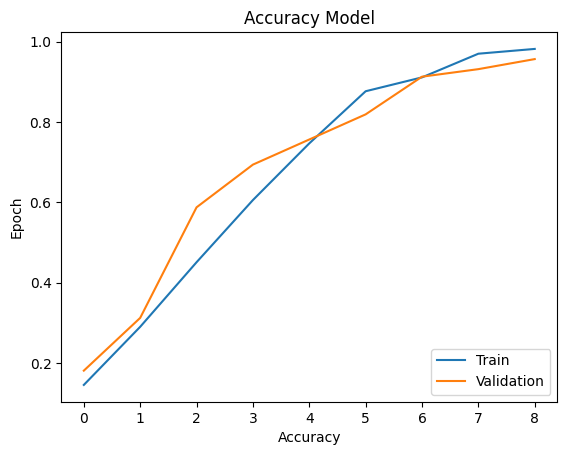

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy Model")
plt.xlabel("Accuracy")
plt.ylabel('Epoch')
plt.legend(['Train', 'Validation'],loc='lower right')
plt.show()

### Menampilkan plot Loss

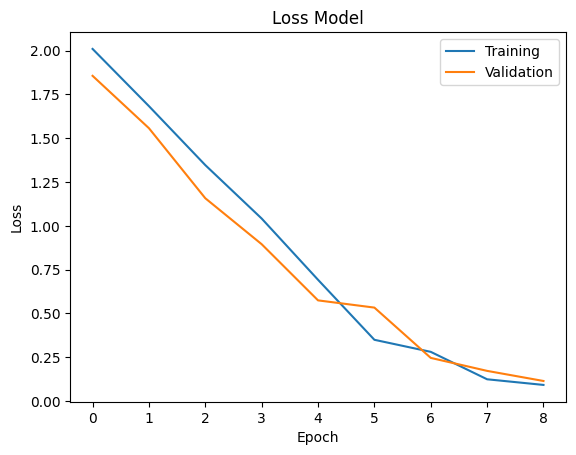

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training','Validation' ],loc='upper right')
plt.show()

In [30]:
# prediction test label
Y_pred = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

# actual test label
y_true = test_generator.classes

# Laporan klasifikasi
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))


12/12 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step
              precision    recall  f1-score   support

        1000       0.90      0.92      0.91        51
       10000       1.00      0.98      0.99        52
      100000       1.00      1.00      1.00        52
        2000       0.91      0.94      0.92        52
       20000       0.98      0.98      0.98        52
        5000       1.00      0.96      0.98        52
       50000       1.00      1.00      1.00        54

    accuracy                           0.97       365
   macro avg       0.97      0.97      0.97       365
weighted avg       0.97      0.97      0.97       365



In [20]:
test_loss, test_acc = model.evaluate(test_generator, steps=5, verbose=1)
print(f"Akurasi pada test set: {test_acc * 100:.2f}%")


5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.9536 - loss: 0.1562
Akurasi pada test set: 96.88%


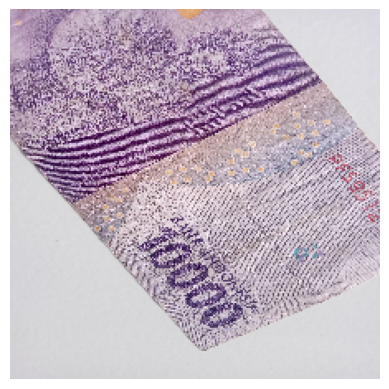

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Prediksi: 10000


In [21]:
# Test modell

image_path = '/content/drive/MyDrive/Colab Notebooks/klasifikasi_gambar/rupiah/10000/IMG20210327135101.jpg'

# Load & proses gambar
img = image.load_img(image_path, target_size=(224, 224))
plt.imshow(img)
plt.axis('off')
plt.show()

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x /= 255.0

# Prediksi
prediction = model.predict(x)


predicted_class_index = np.argmax(prediction)
class_labels = list(train_generator.class_indices.keys())
predicted_label = class_labels[predicted_class_index]

print(f"Prediksi: {predicted_label}")


## Konversi Model

In [22]:
# simpan model dalam format SavedModel, TFLite dan TFJS
export_dir = '/content/drive/My Drive/Colab Notebooks/klasifikasi_gambar/exported_model'
saved_model_dir = os.path.join(export_dir, 'saved_model')
tflite_model_path = os.path.join(export_dir, 'model.tflite')
tfjs_model_dir = os.path.join(export_dir, 'tfjs_model')

os.makedirs(export_dir, exist_ok=True)


In [23]:
model.export(saved_model_dir)
print(f"berhasil simpan model dalam format SavedModel")

Saved artifact at '/content/drive/My Drive/Colab Notebooks/klasifikasi_gambar/exported_model/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  134112045820688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134112001900368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134112001899408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134112045820496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134112045820880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134112045822992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134112045821648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134112045821456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134112002081616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134112002083152

In [24]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)
print(f"berhasil simpan model dalam format TFLite")

berhasil simpan model dalam format TFLite


In [25]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [26]:
!cp -r "/content/drive/My Drive/Colab Notebooks/klasifikasi_gambar/exported_model/saved_model" /content/


!tensorflowjs_converter \
  --input_format=tf_saved_model \
  --output_format=tfjs_graph_model \
  "/content/saved_model" \
  "/content/tfjs_model"


from google.colab import files
import os

for f in os.listdir("/content/tfjs_model"):
    files.download(f"/content/tfjs_model/{f}")

2025-04-19 05:59:26.668451: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745042366.812180   19293 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745042366.841392   19293 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-04-19 05:59:49.937743: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
I0000 00:00:1745042390.533926   19293 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference (Optional)